<a href="https://colab.research.google.com/github/TruomghocAI/YOLOv8/blob/main/YOLOv8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [ ]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.8/78.2 GB disk)


In [ ]:
import os
import cv2
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
import yaml
from ultralytics import YOLO

###Standardized data

In [ ]:
!gdown 1kdypEb7Q0NFSg0Ct7PeG0akVlnYxlhZp

Downloading...
From (original): https://drive.google.com/uc?id=1kdypEb7Q0NFSg0Ct7PeG0akVlnYxlhZp
From (redirected): https://drive.google.com/uc?id=1kdypEb7Q0NFSg0Ct7PeG0akVlnYxlhZp&confirm=t&uuid=dafeb3ef-4f65-427c-8085-edf9479e859d
To: /content/car_object_detection.zip
100% 118M/118M [00:02<00:00, 51.5MB/s]


In [ ]:
!unzip car_object_detection.zip

Archive:  car_object_detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg  
  inflating: data/testing_images/vid_5_26600.jpg  
  inflating: data/testing_images/vid_5_26620.jpg  
  inflating: data/testing_images/vid_5_26640.jpg  
  inflating: data/testing_images/vid_5_26660.jpg  
  inf

In [ ]:
train_data_dir = '/content/data/training_images'
label_filepath = '/content/data/train_solution_bounding_boxes (1).csv'
df = pd.read_csv(label_filepath)
df.head()
# YOLO: x_center, y_center, width, height
# PascalVOC -> YOLO
# (x_min, y_min, x_max, y_max) -> (x_center, y_center, width, height)

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

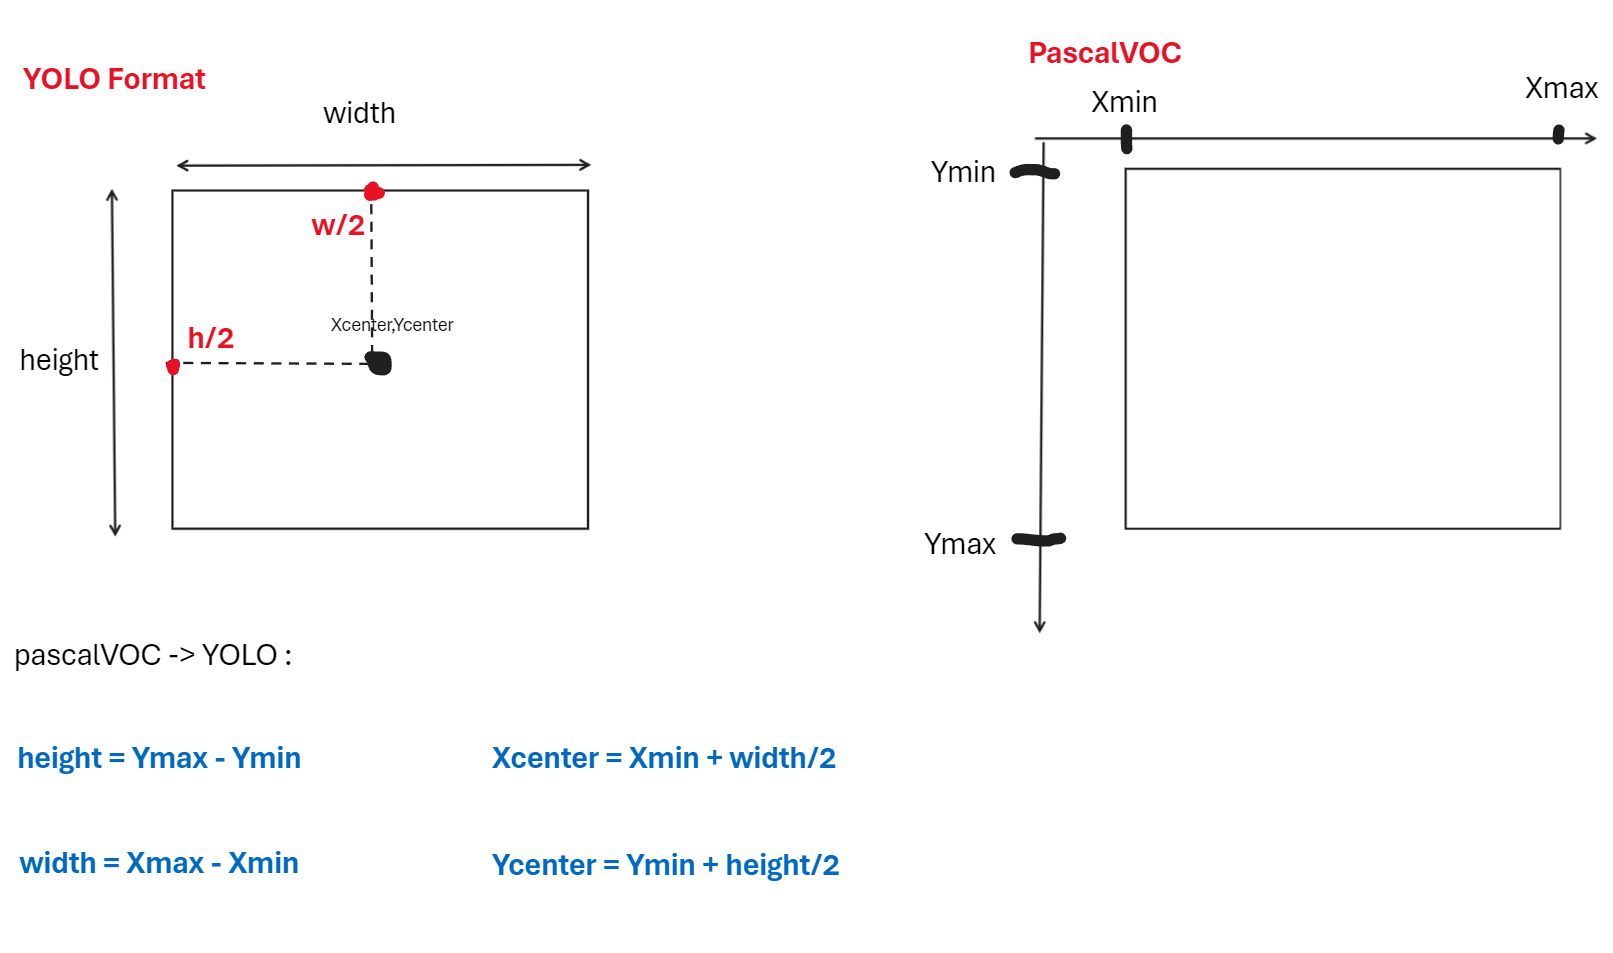

In [ ]:
pil_img = Image.open('/content/data/testing_images/vid_5_25100.jpg')
img_width, img_height = pil_img.size


In [ ]:
df['class'] = 0
df.rename(columns={'image':'img_name'}, inplace=True)

df['x_center'] = (df['xmin'] + df['xmax']) / 2
df['y_center'] = (df['ymin'] + df['ymax']) / 2
df['bbox_w'] = df['xmax'] - df['xmin']
df['bbox_h'] = df['ymax'] - df['ymin']

df['x_center'] = df['x_center'] / img_width
df['y_center']= df['y_center'] / img_height
df['bbox_w'] = df['bbox_w'] / img_width
df['bbox_h'] = df['bbox_h'] / img_height

class_labels = ['car']
yolo_df = df[['img_name', 'class', 'x_center', 'y_center', 'bbox_w', 'bbox_h']]
yolo_df

img_name  class  x_center  y_center    bbox_w    bbox_h
0     vid_4_1000.jpg      0  0.450434  0.539817  0.068741  0.095238
1    vid_4_10000.jpg      0  0.100217  0.557191  0.155572  0.129987
2    vid_4_10040.jpg      0  0.444645  0.543678  0.181621  0.157014
3    vid_4_10020.jpg      0  0.833213  0.531451  0.197540  0.155727
4    vid_4_10060.jpg      0  0.110347  0.559122  0.171491  0.136422
..               ...    ...       ...       ...       ...       ...
554   vid_4_9860.jpg      0  0.036417  0.571770  0.072833  0.099741
555   vid_4_9880.jpg      0  0.640932  0.535500  0.305899  0.247409
556   vid_4_9900.jpg      0  0.104880  0.536148  0.209760  0.186528
557   vid_4_9960.jpg      0  0.816824  0.527728  0.191551  0.148964
558   vid_4_9980.jpg      0  0.421704  0.553635  0.187910  0.146373

[559 rows x 6 columns]

In [ ]:
seed = 0
val_size = 0.05
is_shuffle = True

train_data, val_data = train_test_split(
    yolo_df,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

### Save data

In [ ]:
def save_data(df, src_img_dir, save_dir):
    # Create folder if not exists
    os.makedirs(save_dir, exist_ok=True)

    # Make images and labels folder
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok=True)

    yolo_labels = []

    for idx, row in df.iterrows():
        img_name = row['img_name']
        class_id = row['class']
        x_center = row['x_center']
        y_center = row['y_center']
        bbox_w = row['bbox_w']
        bbox_h = row['bbox_h']

        img_path = os.path.join(src_img_dir, img_name)

        # Copy image to images folder
        shutil.copy(
            os.path.join(src_img_dir, img_path),
            os.path.join(save_dir, 'images')
        )

        img_name = os.path.splitext(img_name)[0]
        label = f'{class_id} {x_center} {y_center} {bbox_w} {bbox_h}'
        yolo_labels.append((img_name, label))

    for img_name, label in yolo_labels:
        with open(os.path.join(save_dir, 'labels', f'{img_name}.txt'), 'a') as f:
            f.write(f'{label}\n')

In [ ]:
save_yolo_data_dir = 'yolo_data'
os.makedirs(save_yolo_data_dir, exist_ok=True)
save_train_dir = os.path.join(save_yolo_data_dir, 'train')
save_val_dir = os.path.join(save_yolo_data_dir, 'val')

save_data(train_data, train_data_dir, save_train_dir)
save_data(val_data, train_data_dir, save_val_dir)

### Create yaml file

In [ ]:
data_yaml = {
    'path': '/content/yolo_data',
    'train': 'train/images',
    'test': 'test/images',
    'val': 'val/images',
    'nc': 1,
    'names': class_labels
}

yolo_yaml_path = os.path.join(
    save_yolo_data_dir,
    'data.yml'
)
with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

## Training model

In [ ]:
# Su dung model YOLOv8s de train
yolo_yaml_path = 'yolo_data/data.yml'
model = YOLO('yolov8s.yaml').load('yolov8s.pt') # tạo biến model gán model YOLO và load file

100%|██████████| 21.5M/21.5M [00:00<00:00, 165MB/s]


Transferred 355/355 items from pretrained weights


In [ ]:
# Set up some important parameters
epochs = 25
imgsz = 640
batch_size = 8
patience = 5
lr = 0.0005

results = model.train(
    data=yolo_yaml_path,
    epochs=epochs,
    imgsz=imgsz,
    batch=batch_size,
    lr0=lr,
    patience=patience,
    project='models',
    name='yolov8/detect/train'
)

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=models/yolov8/detect/train2/weights/best.pt, data=yolo_data/data.yml, epochs=25, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=models, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

train: Scanning /content/yolo_data/train/labels.cache... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/yolo_data/val/labels.cache... 26 images, 0 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]


Plotting labels to models/yolov8/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to models/yolov8/detect/train3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.79G      1.718      2.008      1.441          3        640: 100%|██████████| 44/44 [00:11<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         26         28      0.264      0.143     0.0984     0.0461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.74G      1.311      1.128      1.155          1        640: 100%|██████████| 44/44 [00:10<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]

                   all         26         28      0.445      0.821       0.43      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.76G      1.305      1.005      1.119          7        640: 100%|██████████| 44/44 [00:10<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         26         28      0.396      0.964      0.508      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      2.75G       1.32     0.9009      1.136          5        640: 100%|██████████| 44/44 [00:09<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]

                   all         26         28      0.412      0.893      0.484      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.71G      1.241     0.8315      1.107          1        640: 100%|██████████| 44/44 [00:10<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         26         28      0.404      0.964      0.507      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      2.73G      1.241     0.7754      1.101         13        640: 100%|██████████| 44/44 [00:08<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.99it/s]

                   all         26         28       0.42      0.964       0.45      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.71G      1.223     0.7452      1.088          2        640: 100%|██████████| 44/44 [00:12<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         26         28      0.425      0.929      0.502      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.73G      1.174     0.7002      1.075          4        640: 100%|██████████| 44/44 [00:12<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

                   all         26         28      0.428      0.962      0.465      0.286
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



8 epochs completed in 0.029 hours.
Optimizer stripped from models/yolov8/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from models/yolov8/detect/train3/weights/best.pt, 22.5MB

Validating models/yolov8/detect/train3/weights/best.pt...
Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


                   all         26         28      0.396      0.964      0.508      0.333
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to models/yolov8/detect/train3


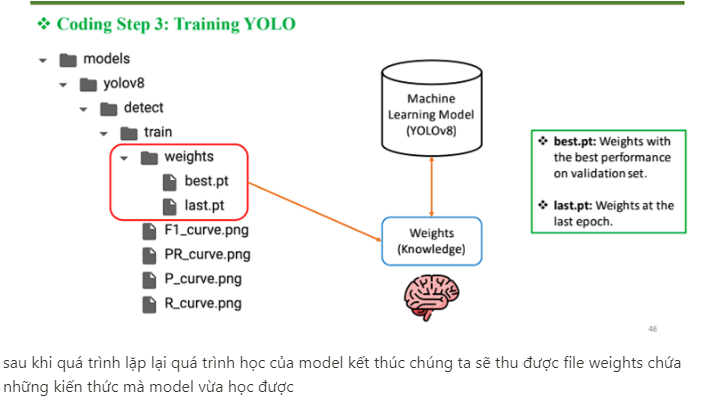

## Inference

### Train ảnh lẻ

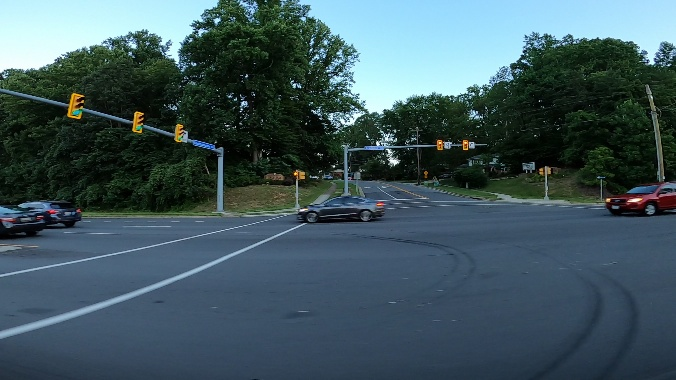

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# dữ liệu trước khi train model
img = cv2.imread('/content/yolo_data/train/images/vid_4_2080.jpg',1) # doc du lieu anh 2 chieu
cv2_imshow(img)

In [ ]:
from ultralytics import YOLO

model_path = 'models/yolov8/detect/train2/weights/best.pt'
test_img_path = '/content/yolo_data/train/images/vid_4_2080.jpg'

model = YOLO(model_path)
model.predict(test_img_path,save = True)


image 1/1 /content/yolo_data/train/images/vid_4_2080.jpg: 384x640 4 cars, 165.1ms
Speed: 9.4ms preprocess, 165.1ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'car'}
 obb: None
 orig_img: array([[[255, 241, 192],
         [254, 240, 191],
         [253, 239, 190],
         ...,
         [253, 224, 173],
         [253, 224, 173],
         [253, 224, 173]],
 
        [[255, 241, 192],
         [254, 240, 191],
         [254, 240, 191],
         ...,
         [253, 224, 173],
         [253, 224, 173],
         [253, 224, 173]],
 
        [[254, 240, 191],
         [254, 240, 191],
         [254, 240, 191],
         ...,
         [253, 224, 173],
         [253, 224, 173],
         [253, 224, 173]],
 
        ...,
 
        [[ 60,  48,  36],
         [ 59,  47,  35],
         [ 59,  47,  35],
         ...,
         [ 56,  43,  27],
         [ 56,  43,  27],
         [ 57,  44,  28]],
 
        [[ 60,  48,  36],
         [ 59,  47,  35],
         [ 59,  47,  35],
         ...,
         [ 57,  44,  

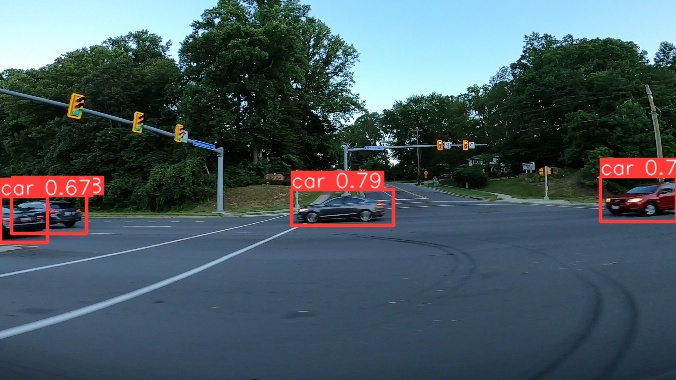

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
# dữ liệu sau khi đi qua model
img = cv2.imread("/content/runs/detect/predict/vid_4_2080.jpg",1) # doc du lieu anh 2 chieu
cv2_imshow(img)

### Train toàn bộ ảnh trong folder

In [ ]:
import os
from ultralytics import YOLO

model_path = 'models/yolov8/detect/train2/weights/best.pt' # khởi tạo model
test_img_dir = '/content/yolo_data/val/images' # lấy dữ liệu trong folder images

model = YOLO(model_path)

for img_name in os.listdir(test_img_dir): #duyệt qua từng file trong folder bằng hàm 0s.listtdir()
    # print(img_name)
    img_path = os.path.join(test_img_dir, img_name) # nối đường dẫn data từ folder đến biến
    #print(img_path)
    results = model.predict(img_path, save=True)
    #lưu từng đường dẫn vào 1 folder mới


image 1/1 /content/yolo_data/val/images/vid_4_17560.jpg: 384x640 4 cars, 59.2ms
Speed: 5.7ms preprocess, 59.2ms inference, 12.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2

image 1/1 /content/yolo_data/val/images/vid_4_9260.jpg: 384x640 2 cars, 30.5ms
Speed: 12.3ms preprocess, 30.5ms inference, 9.8ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2

image 1/1 /content/yolo_data/val/images/vid_4_12140.jpg: 384x640 2 cars, 17.7ms
Speed: 2.3ms preprocess, 17.7ms inference, 21.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2

image 1/1 /content/yolo_data/val/images/vid_4_6280.jpg: 384x640 6 cars, 18.1ms
Speed: 2.3ms preprocess, 18.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2

image 1/1 /content/yolo_data/val/images/vid_4_21260.jpg: 384x640 2 cars, 12.7ms
Speed: 2.1ms preprocess, 12.7ms inference, 1.7ms postp

In [ ]:
import cv2
import json
import matplotlib.pyplot as plt

def visualize_bbox(
    img_path, predictions,
    conf_thres=0.8,
    font=cv2.FONT_HERSHEY_SIMPLEX
):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction['confidence']

        if conf_score < conf_thres:
            continue

        bbox = prediction['box']
        xmin = int(bbox['x1'])
        ymin = int(bbox['y1'])
        xmax = int(bbox['x2'])
        ymax = int(bbox['y2'])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)


        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(img, (xmin, ymin - text_height - 5), (xmin + text_width, ymin), (0, 255, 0), -1)
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)

    return img

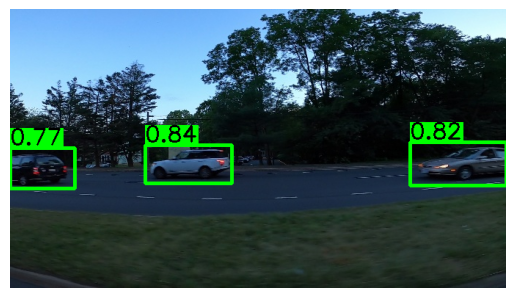

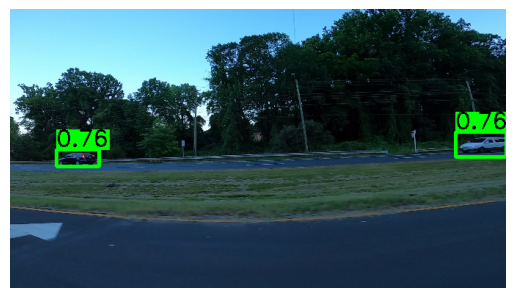

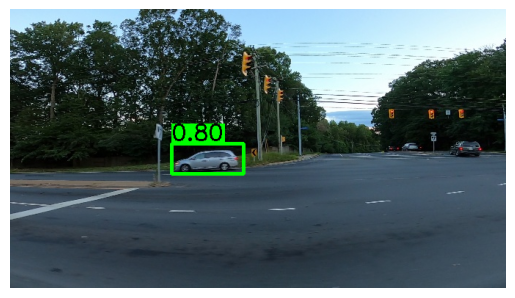

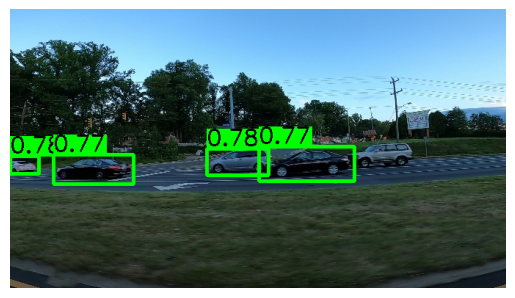

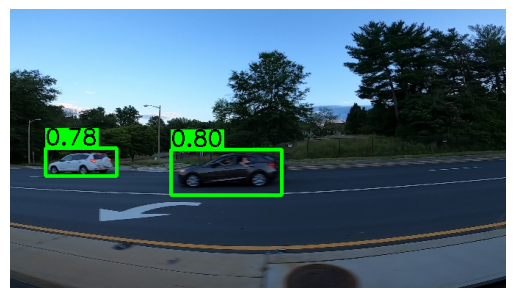

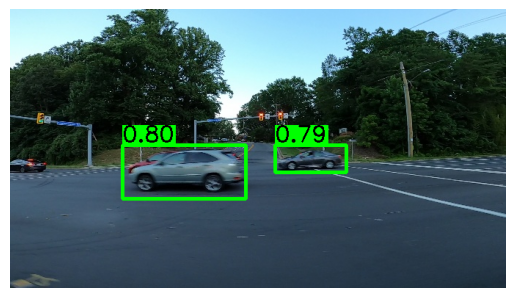

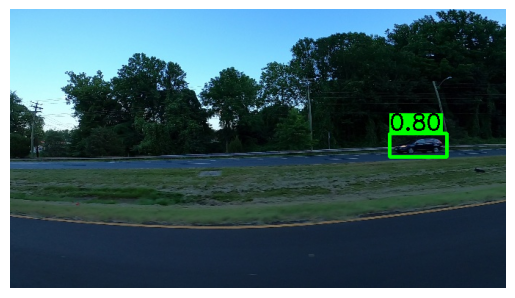

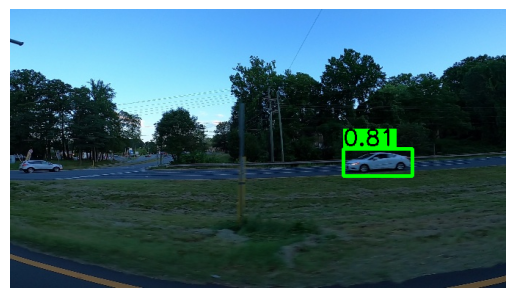

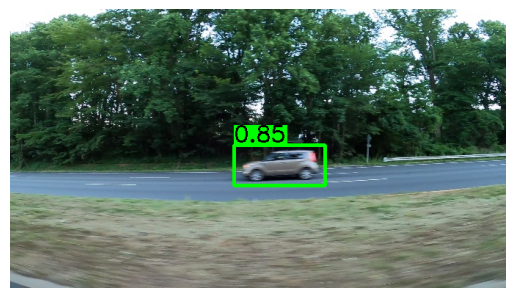

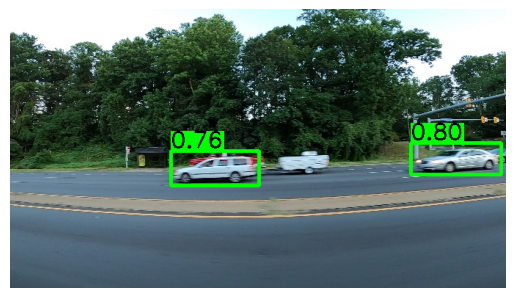

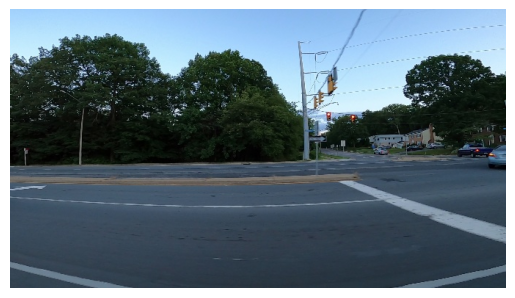

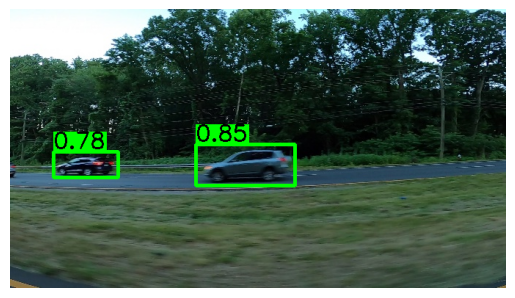

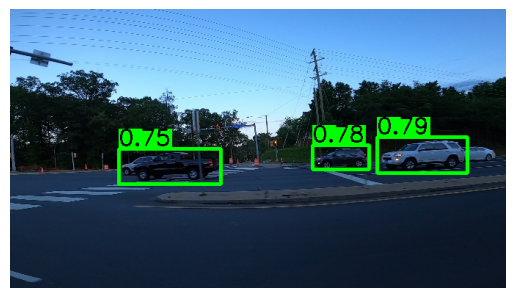

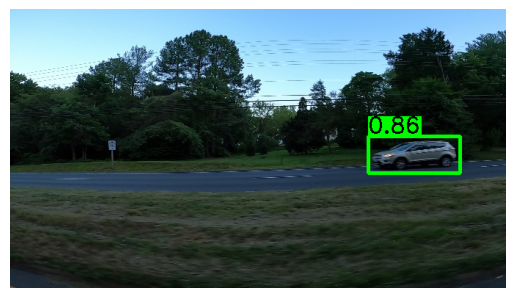

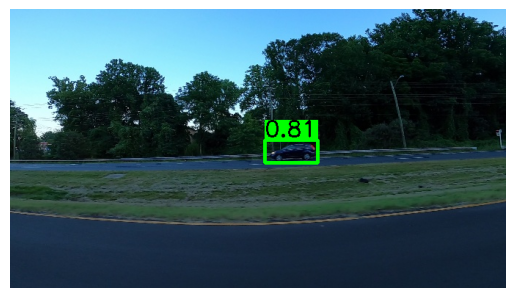

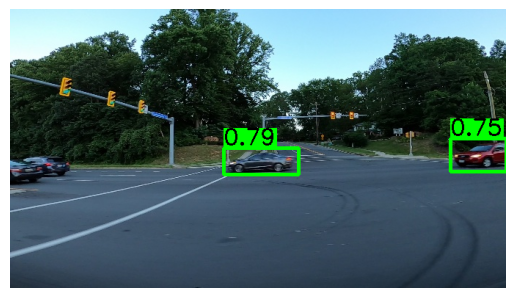

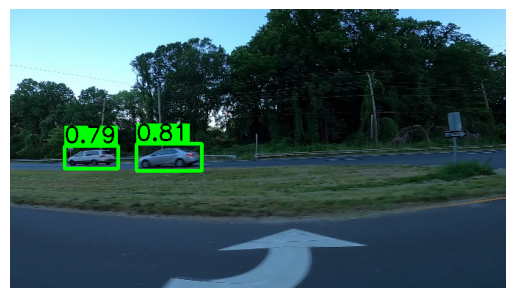

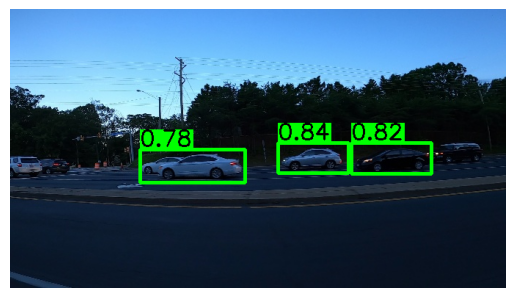

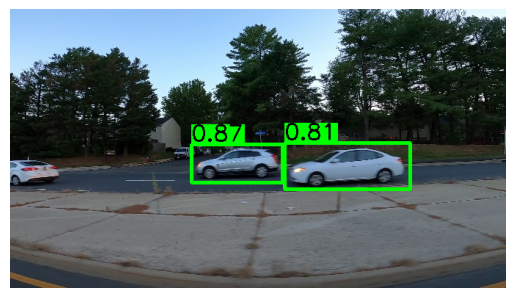

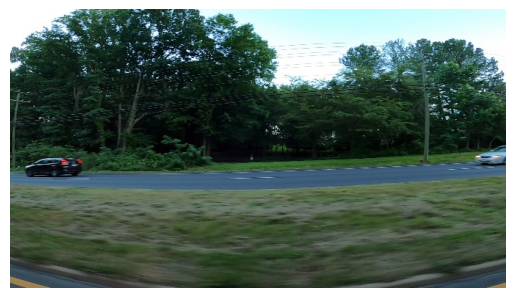

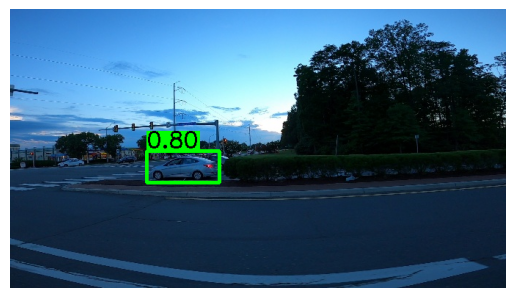

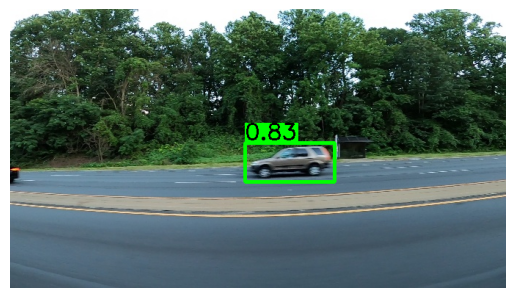

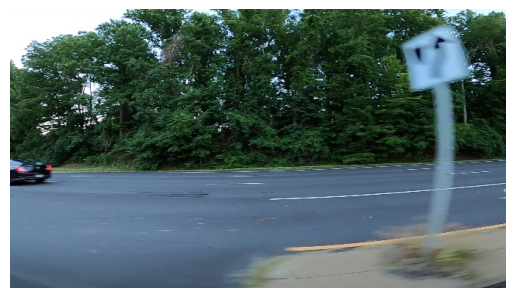

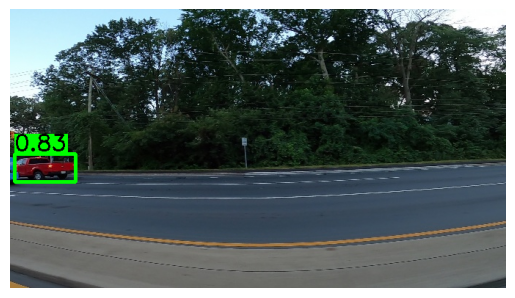

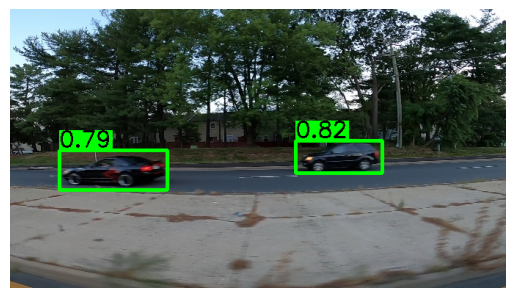

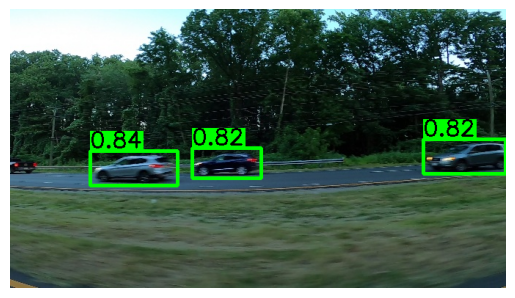

In [ ]:
import os
import json
from ultralytics import YOLO

model_path = 'models/yolov8/detect/train2/weights/best.pt'
test_img_dir = '/content/yolo_data/val/images'
conf_thres=0.75

model = YOLO(model_path)
for img_name in os.listdir(test_img_dir):
    img_path = os.path.join(test_img_dir, img_name)

    # Run inference
    results = model(img_path, verbose=False)
    predictions = json.loads(results[0].tojson())
    visualized_img = visualize_bbox(img_path, predictions, conf_thres)


    %matplotlib inline
    plt.imshow(visualized_img)
    plt.axis('off')
    plt.show()

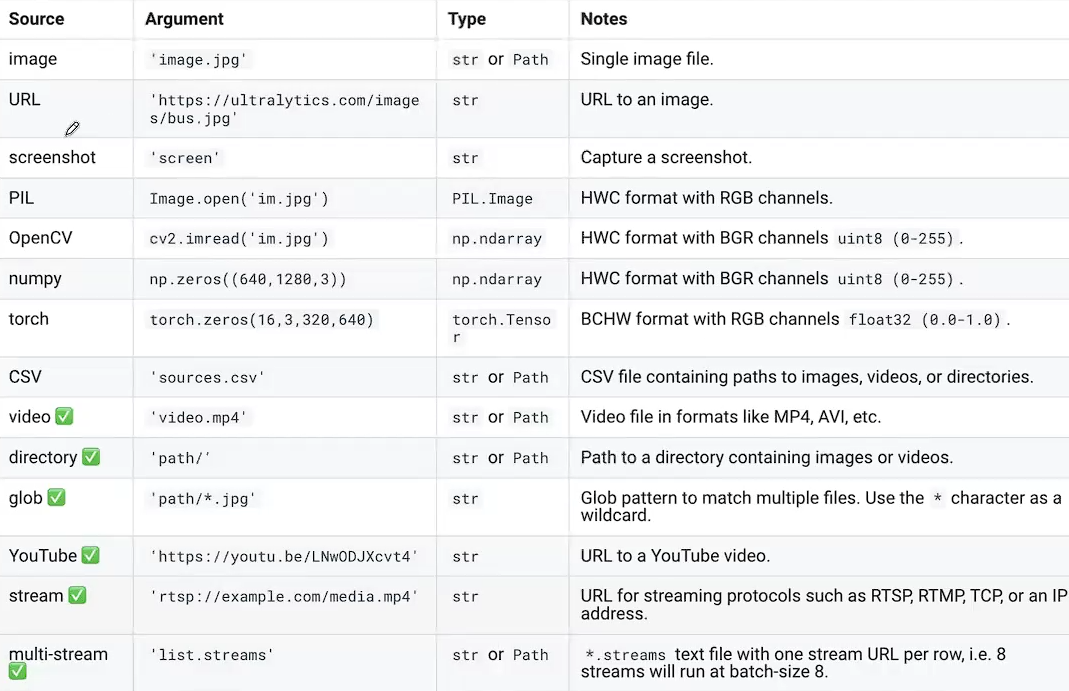

In [ ]:
from ultralytics import YOLO

model_path = 'models/yolov8/detect/train2/weights/best.pt'
test_img_dir = '/content/yolo_data/val/images'
conf_thres=0.75

model = YOLO(model_path)
results = model.predict(
    '/content/2103099-uhd_3840_2160_30fps.mp4',
    save=True
)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/1800) /content/2103099-uhd_3840_2160_30fps.mp4: 384x640 1 car, 12.1ms
video 1/1 (frame 2/1800) /content/2103099-uhd_3840_2160_30fps.mp4: 384x640 (no detections), 14.9ms
video 1/1 (frame 3/1800) /content/2103099-uhd_3840_2160_30fps.mp4: 384x640 (no detections), 15.4ms
video 1/1 (frame 4/1800) /content/2103099-uhd_3840_2160_30fps.mp4: 384x640 (no detections), 14.9ms
video 1/1 (frame 5/1800) /content/2103099-uhd_3840_2160_30fps.mp4: 384